# Autoregressive Moving Average Model

**Harry's Notes**
- Intuitive intro to the concepts - explain why might we think that using moving averages and autoregression would be useful, and also explain what they are
- Intro to the algorithm mathematically
- Code up the constituent parts, broken up with explanations
- Use what we've coded up on a demo dataset


**Joao's Notes**
- Motivation for the notebook. Why do we care about time series analysis? What is it used for in the real-world (and data science)?
- Technical intro: what is a time series? What is stationarity (short distinction between strong and weak-sense stationarity, no equations necessary for this)? Augmented Dick-Fuller (Hypothesis) Test for stationarity (no need for maths, just the intuition of how it works)
- What is autocorrelation and how is it calculated? (Simple equations may be useful). What is partial autocorrelation?
- Theoretical background also on moving average and autoregressive models: equations, what do they mean, intuitively, what is it trying to do?
- In terms of the AR models, expand on the heuristic approach to finding the optimal coefficients (Maybe a simple coding challenge you can set up for the students? We like to include points in our material for students to code themselves so that they don’t die of boredom within 4h of heavy content)

- Mention Yule-Walker equation in the theory as a method of computation of coefficients and link in a useful source for understand these yule-walker equations

- Just before you show the theoretical equations for ARMA, hint at them why neither AR nor MA models are sufficient and why
- Just before interactive code cell, add a description of what we expect to see: interpretation of ACFs and PACFs for given models, why this model performs better than AR and MA
- Before ARIMA, be very clear why ARMA models SUCK for nonstationary data, hence we need ARIMA
- Finish the notebook with an brief introduction of seasonality and just mentioning SARIMA, and a conclusion of the models looked at were, which performed better under what conditions and their shortcomings,

## Introduction

Predicting the future is a challenging problem, especially if we have limited knowledge about a given phenomenon. However, we can still learn from past patterns to make an educated projection of the future.
Timeseries are observational data of a given metric across time (e.g., daily change in temperature during a month). Analysis of these datasets allows us to disentangle regularities in historical observations (e.g., the temperature rises in summer and decreases in winter) and use them to make an informed decision about the future's potential changes.

Regularities in data are also known as stationarity, the fact that we assume that the mechanism by which a given metric is generated is static over time. In other words, It doesn't mean that the series doesn't change over time, just that the way it changes does not itself change over time.

Stationarity can be either **weak** (when the distribution of time-series has a constant mean and variance) or **strong** (if the time-series has the same distribution over any time interval). Since stationarity is an essential assumption, we will illustrate how we could test if our time-series check this assumption before jumping into the forecasting procedure.

## Learning Outcomes
1. Understanding the rationale behind ARMA models
2. Breaking down the theoritical background of the model
3. A Python implimentation on timeseries data

## ARMA Model
ARMA model is a forecasting procedure that combines Auto Regression (AR) and Moving Average (MA) models:
- AR: Auto Regression refers to the fact that we predict a future observation given historical data. In other words, the model converges towards a long term momentum. The formula for the AR model is mainly a linear equation of the form:
$$Y_t=\alpha_0+\alpha_1\times Y_{t-1}+\alpha_2\times Y_{t-2}+...+\alpha_p\times Y_{t-p}$$
Where $Y$ stands for the outcome variable and $p$ marks how many steps back in time that we included in our AR model


- MA: Moving Average refers to the prediction procedure that incorporates the error from our past predictions to minimize future predictions' errors. The formula is also a linear equation of the form:
$$Y_t=\beta_0+\beta_1\times\epsilon_{t-1}+\beta_2\times\epsilon_{t-2}+...+\beta_q\times\epsilon_{t-q}$$
Where $\epsilon$ stands for the error in previous predictions and $q$ marks how many steps back in time that we included in our MA model


In the following example, we experiment with AR and MA models on historical data on icecream production in the United States

In [49]:
# Importing the packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARMA

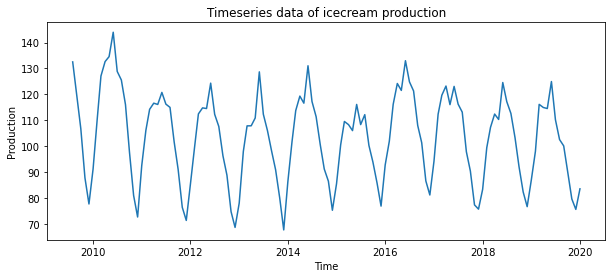

In [42]:
'''
VISUALIZATION OF THE TIMESERIES DATASET
Steps:
    1. Loading the data using Pandas package
    2. Changing the type of the time column into datatime
    3. Extract a portion of the data (10 years of monthly ice cream production levels)
    4. Draw the timeseries graph
'''

full_data = pd.read_csv('C:/Users/Taha/Desktop/ice_cream.csv')
full_data['DATE']= pd.to_datetime(full_data['DATE'], format='%Y-%m-%d')
data = full_data[full_data.index > 450]
plt.figure(figsize=(10, 4)); plt.ylabel('Production'); plt.xlabel('Time')
plt.plot(data.DATE, data.IPN31152N), plt.title('Timeseries data of icecream production');

In [52]:
'''
STATIONARITY TEST
As we mentioned in the introduction, we need to check for the stationarity
before running the ARMA model. We employ the Augmented Dick-Fuller Hypothesis Test
in the following cell using the icecream prosuction dataset

The Dickey Fuller test is one of the most popular statistical tests. 
It can be used to determine the presence of unit root in the series, 
and hence help us understand if the series is stationary or not. 
The null and alternate hypothesis of this test are:
- Null Hypothesis: The series has a unit root (value of a =1)
- Alternate Hypothesis: The series has no unit root.

If the test statistic is less than the critical value, 
we can reject the null hypothesis (aka the series is stationary). 
When the test statistic is greater than the critical value, 
we fail to reject the null hypothesis (which means the series is not stationary).
'''

from statsmodels.tsa.stattools import adfuller
def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value',
                                             '#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

adf_test(data.IPN31152N)

Results of Dickey-Fuller Test:
Test Statistic                  -2.884960
p-value                          0.047125
#Lags Used                      12.000000
Number of Observations Used    113.000000
Critical Value (1%)             -3.489590
Critical Value (5%)             -2.887477
Critical Value (10%)            -2.580604
dtype: float64


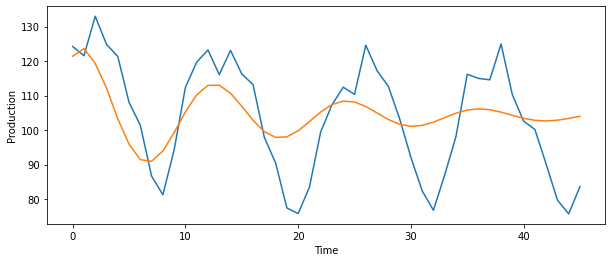

In [43]:
'''
RUNNING AR MODEL
In this cell, we train the AR model on the first seven years of the data
then we try to forecast the coming three years.

Steps are as follow:
    1. decide on the parameter of p for the AR model: p stands for the number of 
    timesteps that our forecasting equation incorporates as input. In this case (p=5), 
    we will discuss some heuristics on picking its value.
    
    2. we fit the model through the historical data using the function "model.fit()"
    
    3. We generate a prediction for three years ahead then compare them against the true 
        observations of the ice cream productions.
'''

model = ARMA(data['IPN31152N'].values[:80], order=(5, 0))
model_fit = model.fit()
predictions = model_fit.predict(start=80, end=125)
plt.figure(figsize=(10, 4)); plt.ylabel('Production'); plt.xlabel('Time')
plt.plot(data['IPN31152N'].values[80:]); plt.plot(predictions);

We notice that the AR model generated a good fit for the first couple of observations, but as we progress in timesteps the predictions are way off the actual trend. The AR model cenverged to the mean of the timeseries.

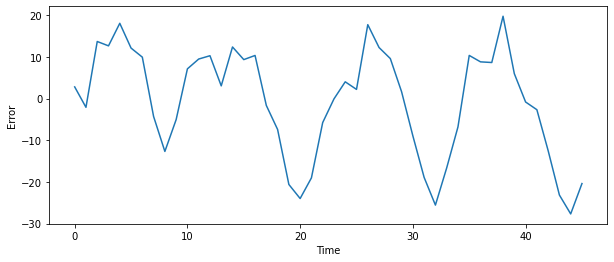

In [36]:
'''
PLOTING THE ERROR OVER TIME
Plotting the error (gap between predicted and actual observation)
This procedure helps us disentangle any missed patters by our model.
We notice that the error is producing a regular pattern that the model didn't capture
'''
plt.figure(figsize=(10, 4)); plt.ylabel('Error'); plt.xlabel('Time')
plt.plot(data['IPN31152N'].values[80:]-predictions);

## Theoritical Background

The AR model misses the information on the accumulated error over time, whereas the MA model fails to capture the time-series' long-term trend. Combining the two would allow us to capture the long-term trend and the seasonalities within every cycle.

The theoritical equation for the $ARMA(p=1, q=1)$ model is simply a sum of the Auto Regression equation and the Moving Average equation. The two equations show that $\epsilon_{t}$ is the difference between an observation and a prediction. The variable stands for the error in the current time step.

The model parameters, namely p and q, are the number of time steps that the equation has to account for in the AR and MA expression. In other words, the number of time steps that we use for AR and MA might be different.

The equation read as follow: The current time prediction $Y_{t}$ is the sum of the auto-regression (AR) and the moving average (MA) but without the current error as we ignore the actual value of $Y$ at time $t$.

![ARMA.jpg](https://raw.githubusercontent.com/Tahahaha7/Econometrics_and_Economic_Systems/master/ARMA.jpg)

In [48]:
'''
In this cell, we experiment with different values of p and q
to produce the best fit for the model.
Try multiple values of p and q and try to find the best combination.
'''
from ipywidgets import interact, Dropdown

p = Dropdown(options = [1, 2, 3, 4, 5])
q = Dropdown(options = [1, 2, 3, 4, 5])

@interact(P = p, Q = q)
def plot_arma(P, Q):
    model = ARMA(data['IPN31152N'].values[:80], order=(P, Q))
    model_fit = model.fit()
    predictions = model_fit.predict(start=80, end=125)
    plt.figure(figsize=(10, 4)); plt.ylabel('Production'); plt.xlabel('Time')
    plt.title('ARMA ({},{}) MODEL'.format(P, Q), fontsize=18)
    plt.plot(data['IPN31152N'].values[80:]); plt.plot(predictions);

interactive(children=(Dropdown(description='P', options=(1, 2, 3, 4, 5), value=1), Dropdown(description='Q', o…

## Model's Parameters
The performance of our ARMA forecasting model relies on the parameters' choice $p$ and $q$. But we need to explore the notion of autocorrelation ACF and partial autocorrelation PACF.

- **Autocorrelation Function (ACF)** is defined as the correlation between the current observation with all the past historical observations.
- **Partial Autocorrelation Function(PACF)** is similar to ACF but with a limit to how many historical observations (lags) we choose to look back to as we compute the correlation.

|Conditional Mean Model | ACF Behavior | PACF Behavior|
| --- | --- | --- |
|AR(p) | Tails off gradually	| Cuts off after p lags|
|MA(q) | Cuts off after q lags | Tails off gradually|
|ARMA(p,q) | Tails off gradually | Tails off gradually|

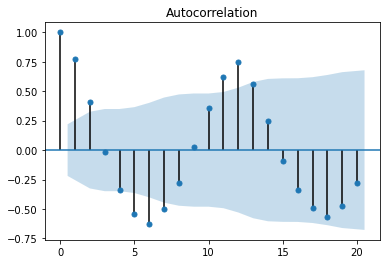

In [46]:
plot_acf(data['IPN31152N'].values[:80]);

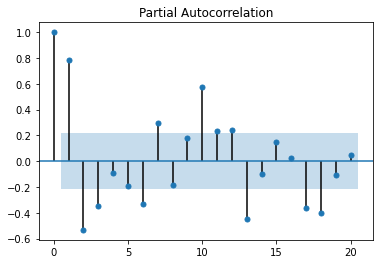

In [190]:
plot_pacf(data['IPN31152N'].values[:80]);

## Models for non-stationary timeseries


True